<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/JR_Depth_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depth Perception Portion of JR Project

First, I load all of the found categories that YOLOv5 has detected and then I'm going to do depth perception on all of the objects. Only the two closest to the user will have haptic feedback.

## 1. Load in YOLOv5

### 1a. Get Google Drive in order to get the YOLOv5 checkpoint file

In [1]:
from google.colab import drive
drive.mount("./content/")

Mounted at ./content/


Check the checkpoint file exists.

In [2]:
from os.path import exists

checkpoint_file = "/content/content/MyDrive/Colab Notebooks/best.pt"
print("Does the checkpoint file exist? ", exists(checkpoint_file))

Does the checkpoint file exist?  True


### 1b. Load YOLOv5 classes and bounding boxes

Import the libraries needed for inference.

In [3]:
!pip install PyYAML==6.0
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 5.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


#### Imports and Settings

In [93]:
%matplotlib inline

from enum import Enum
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

import timm
import torch
import cv2

plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5

#### Setup YOLOv5

Set up GPU on PyTorch

In [10]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Load the YOLOv5 model and get the classes and coords.

In [6]:
print(checkpoint_file)

/content/content/MyDrive/Colab Notebooks/best.pt


In [7]:
'''
Loads the checkpoint file of the pretrained model into PyTorch. We have a custom model so we need to use this to obtain our custom predictions.
'''
def load_model_with_checkpoint(checkpoint_file=''):
  is_checkpoint = len(checkpoint_file) > 0
  model = torch.hub.load("ultralytics/yolov5", 'custom', path=checkpoint_file)
  
  return model

This method gets the bounding boxes of all of the predictions from the chosen YOLOv5 model and returns all of the class labels and bounding box coordinates for each image passed in. Probably want to get the width and height of the `numpy` matrix returned in order to simplify for depth perception.

In [227]:
def get_bboxes(model, images: list):
  # connect the model to PyTorch GPU for faster processing
  model.to(DEVICE)

  # load MY custom predictions for the image
  results = model(images)

  # If you want, can add side effect of printing predictions for each image
  results.print()

  # But most important, use results.xyxy to get bounding boxes for each image
  # Use indexing like results.xyxy[0] to get bounding boxes for all predictions in IMAGE 0
  # for nice formatting in dataframe, use results.pandas()

  return results.pandas().xyxy

Let's test the functions by loading in the checkpoint file.

In reality, the input list would either come from a video where each frame is RGB image or from a live camera view. Here, I'm just using an image for simplicity's sake.

In [179]:
model = load_model_with_checkpoint(checkpoint_file)
images = ["/content/content/MyDrive/Colab Notebooks/test.jpg", "/content/content/MyDrive/Colab Notebooks/constructiontest.jpg"]

bbox_df: list = get_bboxes(model, images)
bbox_df[1].head() # get the bounding boxes

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-6-13 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5m summary: 232 layers, 7278882 parameters, 0 gradients
Adding AutoShape... 


image 1/2: 416x416 2 recycling_bins, 1 trash_bin
image 2/2: 2736x3648 10 barriers, 3 cars, 6 construction_equipments, 1 person
Speed: 97.8ms pre-process, 11.3ms inference, 1.3ms NMS per image at shape (2, 3, 640, 640)


,xmin,ymin,xmax,ymax,confidence,class,name
0,359.719818,473.432220,1356.540405,1251.987061,0.788396,1,car
1,906.252075,878.446899,1621.584229,1366.239014,0.670067,0,barrier
2,0.000000,944.369995,377.384949,2282.014648,0.656926,0,barrier
3,0.000000,851.030762,233.151398,1640.437622,0.650161,9,person
4,3206.864014,1084.620972,3614.857178,1750.464111,0.615306,0,barrier


## Depth Perception Time
Now we do some depth perception on the actual image from YOLOv5. 




### Depth Perception using DPT (Depth Transformer)
Time to setup DPT / MiDas and get some basic depth estimation going. 

*THIS ESTIMATION WILL NOT INCLUDE FINE TUNING.* Fine tuning DPT or a transformer-based neural network will be done later once I create monocular video files for the neural network based on how it was trained.

Right now, just going to do basic inference.

Load required libraries for MiDas and get the model from PyTorch Hub.

In [14]:
# DPT Hybrid is the medium model. Medium inference time, medium accuracy
MODEL_TYPE = "DPT_Hybrid"

midas = torch.hub.load("intel-isl/MiDaS", MODEL_TYPE)

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_hybrid-midas-501f0c75.pt" to /root/.cache/torch/hub/checkpoints/dpt_hybrid-midas-501f0c75.pt


  0%|          | 0.00/470M [00:00<?, ?B/s]

Set the MiDaS model to use the GPU if it is available and set it to inference mode. This will be changed later once I fine-tune the training.

In [16]:
midas.to(DEVICE)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (act): Identity()
                    )
                  )
                  (conv1): S

Get the necessary pre-processing steps from the PyTorch Hub to set up my image for depth evaluation

In [17]:
# different preprocessing required based on type of DPT model selected

midas_preprocess = torch.hub.load("intel-isl/MiDaS", "transforms")
if MODEL_TYPE == "DPT_Large" or MODEL_TYPE == "DPT_Hybrid":
    transform = midas_preprocess.dpt_transform
else:
    transform = midas_preprocess.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load the image into Colab and apply the preprocessing needed.

In [24]:
img = cv2.imread(images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert from BGR to RGB (switch order of channels)

input_batch = transform(img).to(DEVICE)

Predict depth and resize to original resolution.

In [86]:
def quick_predict(input_batch):
  with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=img.shape[:2],
          mode="bicubic",
          align_corners=False,
      ).squeeze()

  output = prediction.cpu().numpy()

  return output

Normalize the image so the thresholding values for depth can be easily calculated for all images instead of different color thresholds for different images.

In [25]:
def normalize(img):
  return img / np.max(img)

output = quick_predict(input_batch)
output = normalize(output)

Show result compared to original image.

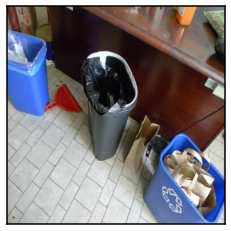

In [99]:
# Original Image
plt.imshow(img)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

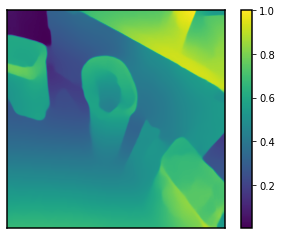

In [100]:
# Depth Image
plt.imshow(output)
plt.colorbar()
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

#### Depth Thresholding
From the normalized values, depth thresholding can be done from the colormap. 

Depth Thresholds: **0 - 0.33, 0.33 - 0.66, 0.66 - 1.00**

Close, Medium Distance, Far Away

Going to create these thresholds using `namedtuple` for some Pythonic code.

In [63]:
Threshold = namedtuple("Threshold", ["lbound", "rbound", "state"])

close_threshold = Threshold(2/3, 1, "Close to {0}. Please move away from the object!")
approach_threshold = Threshold(1/3, 2/3, "Approaching {0}. Be prepared to steer away.")
far_threshold = Threshold(0, 1/3, "Far from {0}.")

If using the 2021 version of **DPT**, you might need to keep the following code cell for use of the *gdown* command to download the pre-trained weights.

In [59]:
# !gdown --id 1dgcJEYYw1F8qirXhZxgNK8dWWz_8gZBD

### Scaling the Bounding Box For Desired Depth Network

This is optional but can be nice for plotting the images in `matplotlib` in case they are the same size. The DPT transform already does all of the preprocessing required for input into DPT Hybrid.

In [250]:
DESIRED_WIDTH = 416 # For Scaling Purposes (not really needed)
DESIRED_HEIGHT = 416 # For Scaling Purposes (not really needed)
CONFIDENCE_THRESHOLD = 5 # how many bounding boxes to load at once

bboxes = get_bboxes(model, images)

for i, image in enumerate(images):
  image_cv = cv2.imread(image)
  width, height, _ = image_cv.shape
  bboxes_current: pd.DataFrame = bboxes[i].head(CONFIDENCE_THRESHOLD)
  for df_index, df_row in bboxes_current.iterrows():
    # resize each of the xmin, ymin, xmax, ymax to match DESIRED WIDTH HEIGHT
    bboxes_current.at[df_index, 'xmin'] = (int(df_row['xmin']) * DESIRED_WIDTH) / width
    bboxes_current.at[df_index, 'xmax'] = (int(df_row['xmax']) * DESIRED_WIDTH) / width
    bboxes_current.at[df_index, 'ymin'] = (int(df_row['ymin']) * DESIRED_HEIGHT) / height
    bboxes_current.at[df_index, 'ymax'] = (int(df_row['ymax']) * DESIRED_HEIGHT) / height
  bboxes[i] = bboxes_current

image 1/2: 416x416 2 recycling_bins, 1 trash_bin
image 2/2: 2736x3648 10 barriers, 3 cars, 6 construction_equipments, 1 person
Speed: 92.9ms pre-process, 11.3ms inference, 1.3ms NMS per image at shape (2, 3, 640, 640)


Show the bounding boxes unscaled.

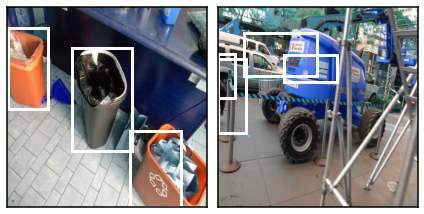

In [251]:
fig, axes = plt.subplots(1, len(bboxes))
THICKNESS = 3

for i, image in enumerate(images):
  image_cv = cv2.imread(image)
  image_cv = cv2.resize(image_cv, (DESIRED_WIDTH, DESIRED_HEIGHT), interpolation = cv2.INTER_AREA)

  axes[i].imshow(image_cv)
  
  bboxes_current: pd.DataFrame = bboxes[i].head(CONFIDENCE_THRESHOLD)
  bboxes_current = bboxes_current.reset_index()
  for df_index, df_row in bboxes_current.iterrows():
    xmin, ymin = (int(df_row['xmin']), int(df_row['ymin']))
    xmax, ymax = (np.ceil(df_row['xmax']), np.ceil(df_row['ymax']))
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=THICKNESS, edgecolor='w', facecolor='none')
    axes[i].add_patch(rect)
    axes[i].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False) 


fig.tight_layout()

### Combine Depth Perception Results With Bounding Boxes

The function below is a quick wrapper function that takes in a loaded `ndarray` image from **OpenCV** and returns its depth mapping color output.

In [252]:
# input is an image in numpy format
def predict_depth(img: np.ndarray, device, model_type="DPT Hybrid") -> np.ndarray:
  if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_preprocess.dpt_transform
  else:
    transform = midas_preprocess.small_transform
  
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_batch = transform(img).to(device)

  output = quick_predict(img_batch)
  return normalize(output)

First, we are going to show the bounding boxes on the depth-estimated image.

(416, 416, 3)
(2736, 3648, 3)


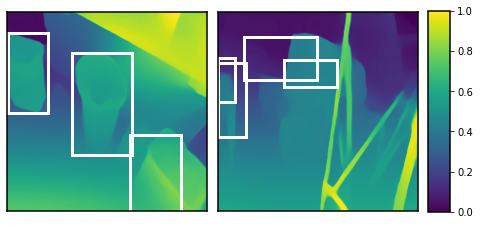

In [253]:
fig, axes = plt.subplots(1, len(bboxes))
color_bar_pos = [1, 0.15, 0.05, 0.7]

for i, image in enumerate(images):
  image_cv = cv2.imread(image)
  # image_cv = cv2.resize(image_cv, (DESIRED_WIDTH, DESIRED_HEIGHT), interpolation = cv2.INTER_AREA)
  print(image_cv.shape)

  depth_image = predict_depth(image_cv, DEVICE)
  # print(depth_image.shape)
  
  depth_color_map = axes[i].imshow(depth_image)

  
  bboxes_current: pd.DataFrame = bboxes[i]
  bboxes_current = bboxes_current.reset_index()
  
  for df_index, df_row in bboxes_current.iterrows():
    xmin, ymin = (int(df_row['xmin']), int(df_row['ymin']))
    xmax, ymax = (np.ceil(df_row['xmax']), np.ceil(df_row['ymax']))
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=THICKNESS, edgecolor='w', facecolor='none')
    axes[i].add_patch(rect)
    axes[i].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

fig.tight_layout()

cbar_ax = fig.add_axes(color_bar_pos)
fig.colorbar(depth_color_map, cax=cbar_ax)

And now we do the actual thresholding for depth.

1. First, we get the conditionals based on the mean depth value in the image.
2. Then, we state the result based on the depth value

We have a enum below to represent the different categories of depth based on how far from the camera the person is.

In [254]:
class DepthColor(Enum):
  CLOSE = '#ff0000'
  APPROACH = '#00ff00'
  FAR = '#0000ff'


In reality, this would include haptic feedback but this is the best I can do in 
a Colab notebook. Perhaps, I can be a bit more specific given where the object is 
in the image but this is a good prototype.


In [255]:
# Function to state the depth based on class and average depth value 
def detect_depth(avg_depth, class_type):
  if close_threshold.lbound <= avg_depth and avg_depth < close_threshold.rbound:
    return (DepthColor.CLOSE, close_threshold.state.format(class_type))
  elif approach_threshold.lbound <= avg_depth and avg_depth < approach_threshold.rbound:
    return (DepthColor.APPROACH, approach_threshold.state.format(class_type))
  else:
    return (DepthColor.FAR, far_threshold.state.format(class_type))

State the result for each image and show depth color map

--------------------------------------------------
0.45316038
Approaching trash_bin. Be prepared to steer away. 

--------------------------------------------------
0.34282953
Approaching recycling_bin. Be prepared to steer away. 

--------------------------------------------------
0.60462594
Approaching recycling_bin. Be prepared to steer away. 

--------------------------------------------------
--------------------------------------------------
0.17093459
Far from car. 

--------------------------------------------------
0.36149848
Approaching barrier. Be prepared to steer away. 

--------------------------------------------------
0.07657653
Far from barrier. 

--------------------------------------------------
0.04642771
Far from person. 

--------------------------------------------------

--------------------------------------------------


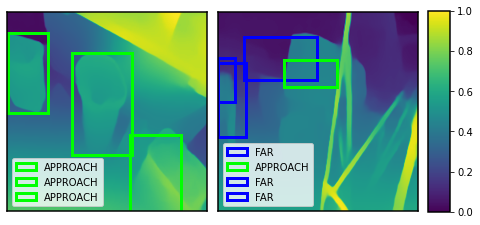

In [256]:
fig, axes = plt.subplots(1, len(bboxes))
for i, image in enumerate(images):
  bboxes_new = []
  
  image_cv = cv2.imread(image)
  # image_cv = cv2.resize(image_cv, (DESIRED_WIDTH, DESIRED_HEIGHT), interpolation = cv2.INTER_AREA)

  depth_image = predict_depth(image_cv, DEVICE)

  ax_image = axes[i].imshow(depth_image)

  bboxes_current: pd.DataFrame = bboxes[i]
  
  print('-' * 50)
  # Index numpy array for all bounding boxes
  for df_index, df_row in bboxes_current.iterrows():
    xmin, ymin = (int(df_row['xmin']), int(df_row['ymin']))
    xmax, ymax = (np.ceil(df_row['xmax']).astype(int), np.ceil(df_row['ymax']).astype(int))
    # print(xmin, xmax, ymin, ymax)
    np_bbox = depth_image[xmin:xmax, ymin:ymax]

    if np_bbox.size != 0:
      bbox_mean_depth = np.mean(np_bbox)
      print(bbox_mean_depth)
      depth_type, msg = detect_depth(bbox_mean_depth, df_row['name'])
      rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                              linewidth=THICKNESS, edgecolor=depth_type.value, label=depth_type.name, facecolor='none')
      axes[i].add_patch(rect)
      bboxes_new.append(depth_type.name)
      print(msg, '\n')
    else:
      print()

    print('-' * 50)
    axes[i].legend(bboxes_new)
    axes[i].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    
fig.tight_layout()
cbar_ax = fig.add_axes(color_bar_pos)
fig.colorbar(depth_color_map, cax=cbar_ax)

##Done with the initial prototype!